In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from sklearn.linear_model import LinearRegression
import h5py
import networkx as nx
from sklearn.neighbors import NearestNeighbors
import maxflow
from PIL import Image, ImageOps
from scipy.spatial import KDTree
from skimage.filters import threshold_otsu
import lifelines
from lifelines import KaplanMeierFitter, CoxPHFitter
from lifelines.statistics import logrank_test
from skimage.filters import threshold_minimum
from skimage.filters import threshold_otsu
from tableone import TableOne
from lifelines.plotting import add_at_risk_counts

# 予後データの読み込み

In [2]:
tcga_rep_data = pd.read_csv('./prog_data/stad_tcga_pan_can_atlas_2018_clinical_data.tsv',delimiter= "\t")

In [3]:
tcga_rep_data.head()

,Study ID,Patient ID,Sample ID,Diagnosis Age,Neoplasm Disease Stage American Joint Committee on Cancer Code,American Joint Committee on Cancer Publication Version Type,Aneuploidy Score,Cancer Type,TCGA PanCanAtlas Cancer Type Acronym,Cancer Type Detailed,...,Subtype,Tumor Break Load,Tissue Prospective Collection Indicator,Tissue Retrospective Collection Indicator,Tissue Source Site,Tissue Source Site Code,TMB (nonsynonymous),Tumor Disease Anatomic Site,Tumor Type,Patient Weight
0,stad_tcga_pan_can_atlas_2018,TCGA-3M-AB46,TCGA-3M-AB46-01,70.0,STAGE IB,6TH,11.0,Esophagogastric Cancer,STAD,Stomach Adenocarcinoma,...,STAD_CIN,110.0,No,Yes,University of Kansas Medical Center,3M,5.600000,Stomach,Stomach Adenocarcinoma (NOS),NaN
1,stad_tcga_pan_can_atlas_2018,TCGA-3M-AB47,TCGA-3M-AB47-01,51.0,STAGE IIIB,6TH,6.0,Esophagogastric Cancer,STAD,Stomach Adenocarcinoma,...,STAD_GS,30.0,No,Yes,University of Kansas Medical Center,3M,3.566667,Stomach,Stomach Adenocarcinoma (NOS),NaN
2,stad_tcga_pan_can_atlas_2018,TCGA-B7-5816,TCGA-B7-5816-01,51.0,STAGE IIB,7TH,2.0,Esophagogastric Cancer,STAD,Diffuse Type Stomach Adenocarcinoma,...,STAD_MSI,48.0,No,Yes,Cureline,B7,40.100000,Stomach,"Stomach Adenocarcinoma, Diffuse Type",NaN
3,stad_tcga_pan_can_atlas_2018,TCGA-B7-5818,TCGA-B7-5818-01,62.0,STAGE IB,7TH,9.0,Esophagogastric Cancer,STAD,Diffuse Type Stomach Adenocarcinoma,...,STAD_EBV,41.0,No,Yes,Cureline,B7,11.500000,Stomach,"Stomach Adenocarcinoma, Diffuse Type",NaN
4,stad_tcga_pan_can_atlas_2018,TCGA-B7-A5TI,TCGA-B7-A5TI-01,52.0,STAGE IIIC,7TH,4.0,Esophagogastric Cancer,STAD,Diffuse Type Stomach Adenocarcinoma,...,STAD_MSI,87.0,Yes,No,Cureline,B7,18.433333,Stomach,"Stomach Adenocarcinoma, Diffuse Type",NaN


In [4]:
tcga_rep_data.columns

Index(['Study ID', 'Patient ID', 'Sample ID', 'Diagnosis Age',
       'Neoplasm Disease Stage American Joint Committee on Cancer Code',
       'American Joint Committee on Cancer Publication Version Type',
       'Aneuploidy Score', 'Cancer Type',
       'TCGA PanCanAtlas Cancer Type Acronym', 'Cancer Type Detailed',
       'Last Communication Contact from Initial Pathologic Diagnosis Date',
       'Birth from Initial Pathologic Diagnosis Date',
       'Last Alive Less Initial Pathologic Diagnosis Date Calculated Day Value',
       'Disease Free (Months)', 'Disease Free Status',
       'Months of disease-specific survival',
       'Disease-specific Survival status', 'Ethnicity Category',
       'Form completion date', 'Fraction Genome Altered',
       'Genetic Ancestry Label', 'Neoplasm Histologic Grade',
       'Neoadjuvant Therapy Type Administered Prior To Resection Text',
       'ICD-10 Classification',
       'International Classification of Diseases for Oncology, Third Edition IC

# 別のdataをrefに

In [5]:
raw_prog_data = pd.read_excel('./prog_data/TCGA-CDR-SupplementalTableS1.xlsx',sheet_name="ExtraEndpoints")
raw_prog_data.head()

,Unnamed: 0,bcr_patient_barcode,type,PFI.1,PFI.time.1,PFI.2,PFI.time.2,PFS,PFS.time,DSS_cr,DSS.time.cr,DFI.cr,DFI.time.cr,PFI.cr,PFI.time.cr,PFI.1.cr,PFI.time.1.cr,PFI.2.cr,PFI.time.2.cr
0,1,TCGA-OR-A5J1,ACC,1.0,754.0,1.0,754.0,1.0,754.0,1.0,1355.0,1.0,754.0,1.0,754.0,1.0,754.0,1.0,754.0
1,2,TCGA-OR-A5J2,ACC,1.0,289.0,1.0,289.0,1.0,289.0,1.0,1677.0,NaN,NaN,1.0,289.0,1.0,289.0,1.0,289.0
2,3,TCGA-OR-A5J3,ACC,1.0,53.0,1.0,53.0,1.0,53.0,0.0,2091.0,1.0,53.0,1.0,53.0,1.0,53.0,1.0,53.0
3,4,TCGA-OR-A5J4,ACC,1.0,126.0,1.0,126.0,1.0,126.0,1.0,423.0,NaN,NaN,1.0,126.0,1.0,126.0,1.0,126.0
4,5,TCGA-OR-A5J5,ACC,1.0,50.0,1.0,50.0,1.0,50.0,1.0,365.0,NaN,NaN,1.0,50.0,1.0,50.0,1.0,50.0


In [6]:
raw_prog_data = pd.merge(tcga_rep_data, raw_prog_data, left_on='Patient ID', right_on='bcr_patient_barcode', how='inner')

In [7]:
raw_prog_data

,Study ID,Patient ID,Sample ID,Diagnosis Age,Neoplasm Disease Stage American Joint Committee on Cancer Code,American Joint Committee on Cancer Publication Version Type,Aneuploidy Score,Cancer Type,TCGA PanCanAtlas Cancer Type Acronym,Cancer Type Detailed,...,DSS_cr,DSS.time.cr,DFI.cr,DFI.time.cr,PFI.cr,PFI.time.cr,PFI.1.cr,PFI.time.1.cr,PFI.2.cr,PFI.time.2.cr
0,stad_tcga_pan_can_atlas_2018,TCGA-3M-AB46,TCGA-3M-AB46-01,70.0,STAGE IB,6TH,11.0,Esophagogastric Cancer,STAD,Stomach Adenocarcinoma,...,0.0,1765.0,0.0,1765.0,0.0,1765.0,0.0,1765.0,0.0,1765.0
1,stad_tcga_pan_can_atlas_2018,TCGA-3M-AB47,TCGA-3M-AB47-01,51.0,STAGE IIIB,6TH,6.0,Esophagogastric Cancer,STAD,Stomach Adenocarcinoma,...,1.0,NaN,NaN,NaN,1.0,395.0,1.0,395.0,1.0,395.0
2,stad_tcga_pan_can_atlas_2018,TCGA-B7-5816,TCGA-B7-5816-01,51.0,STAGE IIB,7TH,2.0,Esophagogastric Cancer,STAD,Diffuse Type Stomach Adenocarcinoma,...,0.0,812.0,0.0,812.0,0.0,812.0,0.0,812.0,0.0,812.0
3,stad_tcga_pan_can_atlas_2018,TCGA-B7-5818,TCGA-B7-5818-01,62.0,STAGE IB,7TH,9.0,Esophagogastric Cancer,STAD,Diffuse Type Stomach Adenocarcinoma,...,0.0,356.0,NaN,NaN,0.0,356.0,0.0,356.0,0.0,356.0
4,stad_tcga_pan_can_atlas_2018,TCGA-B7-A5TI,TCGA-B7-A5TI-01,52.0,STAGE IIIC,7TH,4.0,Esophagogastric Cancer,STAD,Diffuse Type Stomach Adenocarcinoma,...,0.0,595.0,0.0,595.0,0.0,595.0,0.0,595.0,0.0,595.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
435,stad_tcga_pan_can_atlas_2018,TCGA-VQ-AA6I,TCGA-VQ-AA6I-01,68.0,STAGE IIIB,7TH,15.0,Esophagogastric Cancer,STAD,Intestinal Type Stomach Adenocarcinoma,...,1.0,491.0,NaN,NaN,1.0,475.0,1.0,475.0,1.0,475.0
436,stad_tcga_pan_can_atlas_2018,TCGA-VQ-AA6J,TCGA-VQ-AA6J-01,75.0,STAGE IIIB,7TH,9.0,Esophagogastric Cancer,STAD,Intestinal Type Stomach Adenocarcinoma,...,0.0,838.0,0.0,838.0,0.0,838.0,0.0,838.0,0.0,838.0
437,stad_tcga_pan_can_atlas_2018,TCGA-VQ-AA6K,TCGA-VQ-AA6K-01,59.0,STAGE IIIC,6TH,14.0,Esophagogastric Cancer,STAD,Signet Ring Cell Carcinoma of the Stomach,...,1.0,378.0,NaN,NaN,1.0,332.0,1.0,332.0,1.0,332.0
438,stad_tcga_pan_can_atlas_2018,TCGA-ZA-A8F6,TCGA-ZA-A8F6-01,71.0,STAGE IB,7TH,7.0,Esophagogastric Cancer,STAD,Intestinal Type Stomach Adenocarcinoma,...,0.0,525.0,0.0,525.0,0.0,525.0,0.0,525.0,0.0,525.0


In [8]:
raw_prog_data.columns

Index(['Study ID', 'Patient ID', 'Sample ID', 'Diagnosis Age',
       'Neoplasm Disease Stage American Joint Committee on Cancer Code',
       'American Joint Committee on Cancer Publication Version Type',
       'Aneuploidy Score', 'Cancer Type',
       'TCGA PanCanAtlas Cancer Type Acronym', 'Cancer Type Detailed',
       'Last Communication Contact from Initial Pathologic Diagnosis Date',
       'Birth from Initial Pathologic Diagnosis Date',
       'Last Alive Less Initial Pathologic Diagnosis Date Calculated Day Value',
       'Disease Free (Months)', 'Disease Free Status',
       'Months of disease-specific survival',
       'Disease-specific Survival status', 'Ethnicity Category',
       'Form completion date', 'Fraction Genome Altered',
       'Genetic Ancestry Label', 'Neoplasm Histologic Grade',
       'Neoadjuvant Therapy Type Administered Prior To Resection Text',
       'ICD-10 Classification',
       'International Classification of Diseases for Oncology, Third Edition IC

In [9]:
sample_name = [f"{sample_name}-01Z-00-DX1" for sample_name in raw_prog_data["Patient ID"].tolist()]
sample_age = raw_prog_data['Diagnosis Age'].tolist()

sample_T = raw_prog_data['American Joint Committee on Cancer Tumor Stage Code'].str.extract(r'^(T[1-4])')[0].fillna(raw_prog_data['American Joint Committee on Cancer Tumor Stage Code']).tolist()
sample_N = raw_prog_data['Neoplasm Disease Lymph Node Stage American Joint Committee on Cancer Code'].tolist()
sample_M = raw_prog_data['American Joint Committee on Cancer Metastasis Stage Code'].tolist()


age_dict =dict(zip(sample_name, sample_age))

T_dict = dict(zip(sample_name, sample_T))
N_dict = dict(zip(sample_name, sample_N))
M_dict =dict(zip(sample_name, sample_M))


In [10]:
np.unique(raw_prog_data["Subtype"].tolist())

array(['STAD_CIN', 'STAD_EBV', 'STAD_GS', 'STAD_MSI', 'STAD_POLE', 'nan'],
      dtype='<U32')

In [11]:
np.unique(sample_M)

array(['M0', 'M1', 'MX'], dtype='<U2')

In [12]:

###DSS がんによる死亡，DFI 寛解したのちの再発
#prog_data=raw_prog_data[raw_prog_data["bcr_patient_barcode"].isin(sample_name_list_with_tumsize)]

#prog_data=raw_prog_data[raw_prog_data['Neoplasm Disease Stage American Joint Committee on Cancer Code'].isin(['STAGE III', 'STAGE IIIA', 'STAGE IIIB', 'STAGE IIIC'])]

prog_data=raw_prog_data[raw_prog_data["Subtype"]=="STAD_CIN"]
prog_data=prog_data[prog_data['American Joint Committee on Cancer Metastasis Stage Code']=="M0"]
#prog_data=raw_prog_data[raw_prog_data["Subtype"]=="STAD_GS"]

#prog_data = raw_prog_data

prog_data_name = [f"{sample_name}-01Z-00-DX1" for sample_name in prog_data["Patient ID"].tolist()]

OS_df = prog_data[pd.notna(prog_data["Overall Survival Status"])]
#OS_df = prog_data[prog_data["Overall Survival Status"]=="1:DECEASED"]
OS_df = OS_df[pd.notna(OS_df["Overall Survival (Months)"])]
OS_sample_name = [f"{sample_name}-01Z-00-DX1" for sample_name in OS_df["Patient ID"].tolist()]
OS_time = OS_df["Overall Survival (Months)"].tolist()
OS_index = OS_df["Overall Survival Status"].tolist()
OS_index = [int(temp_index[0]) for temp_index in OS_index]
OS_index_dict=dict(zip(OS_sample_name, OS_index))
OS_dict = dict(zip(OS_sample_name, OS_time))


DSS_df = prog_data[pd.notna(prog_data["DSS_cr"])]
#DSS_df = prog_data[prog_data["DSS_cr"]==1]
DSS_df = DSS_df[pd.notna(DSS_df["DSS.time.cr"])]
DSS_sample_name = [f"{sample_name}-01Z-00-DX1" for sample_name in DSS_df["bcr_patient_barcode"].tolist()]
DSS_time = DSS_df["DSS.time.cr"].tolist()
DSS_time=[temp_DSS/30 for temp_DSS in DSS_time]
DSS_index_dict=dict(zip(DSS_sample_name, DSS_df["DSS_cr"].tolist()))
DSS_dict = dict(zip(DSS_sample_name, DSS_time))

PFS_df = prog_data[pd.notna(prog_data["PFS"])]
#PFS_df = prog_data[prog_data["PFS"]==1]
PFS_df = PFS_df[pd.notna(PFS_df["PFS.time"])]
PFS_sample_name = [f"{sample_name}-01Z-00-DX1" for sample_name in PFS_df["bcr_patient_barcode"].tolist()]
PFS_time = PFS_df["PFS.time"].tolist()
PFS_time=[temp_PFS/30 for temp_PFS in PFS_time]
PFS_index_dict=dict(zip(PFS_sample_name, PFS_df["PFS"].tolist()))
PFS_dict = dict(zip(PFS_sample_name, PFS_time))

DFI_df = prog_data[pd.notna(prog_data["DFI.cr"])]
#DFI_df = prog_data[prog_data["DFI.cr"]==1]
DFI_df = DFI_df[pd.notna(DFI_df["DFI.time.cr"])]
DFI_sample_name = [f"{sample_name}-01Z-00-DX1" for sample_name in DFI_df["bcr_patient_barcode"].tolist()]
DFI_time = DFI_df["DFI.time.cr"].tolist()
DFI_time=[temp_DFI/30 for temp_DFI in DFI_time]
DFI_index_dict=dict(zip(DFI_sample_name, DFI_df["DFI.cr"].tolist()))
DFI_dict = dict(zip(DFI_sample_name, DFI_time))

PFI_df = prog_data[pd.notna(prog_data["PFI.cr"])]
#PFI_df = prog_data[prog_data["PFI.cr"]==1]
PFI_df = PFI_df[pd.notna(PFI_df["PFI.time.cr"])]
PFI_sample_name = [f"{sample_name}-01Z-00-DX1" for sample_name in PFI_df["bcr_patient_barcode"].tolist()]
PFI_time = PFI_df["PFI.time.cr"].tolist()
PFI_time=[temp_PFI/30 for temp_PFI in PFI_time]
PFI_index_dict=dict(zip(PFI_sample_name, PFI_df["PFI.cr"].tolist()))
PFI_dict = dict(zip(PFI_sample_name, PFI_time))

prog_dict =PFI_dict
prog_index_dict = PFI_index_dict



In [13]:
!pwd

/data/shirasuna/work/hetero_path/hetero_cluster


In [14]:

def create_knn_graph(coords, k=4):
    """
    k-NNグラフを構築
    - coords: xy座標 (N, 2)
    - features: 各点の特徴量 (N, F) でFは特徴量の次元数
    - k: 近傍数
    """
    n = len(coords)
    
    # k-NNモデルの作成 (xy座標に基づいて近傍を計算)
    neighbors = NearestNeighbors(n_neighbors=k + 1)  # 自分自身を含むため +1
    neighbors.fit(coords)
    
    # k-NNの距離とインデックスを計算
    distances, indices = neighbors.kneighbors(coords)

    # maxflowグラフの作成
    g = maxflow.Graph[int]()
    nodes = g.add_nodes(n)

    # NetworkXでグラフ可視化用
    nx_graph = nx.Graph()

    # k-NNでエッジを追加
    for i in range(n):
        for j in range(1, k + 1):  # 自分自身は除外するため1からスタート
            neighbor_idx = indices[i, j]

            # エッジの重み (featureの相関係数) - 事前に計算した相関行列を使用　cos simが高いほど，weight==異なるclusterになった場合のpenalty は小さい
            weight = 1

            # pymaxflowのグラフにエッジを追加
            g.add_edge(nodes[i], nodes[neighbor_idx], weight, weight)

            # NetworkXのグラフにも追加
            nx_graph.add_edge(i, neighbor_idx, weight=weight)

    return g, nodes, nx_graph





def compute_cluster_connected_components(nx_graph, node_cluster):
    """
    各クラスタの連結成分数と割合を計算
    
    - nx_graph: networkxのグラフ
    - node_cluster: 各ノードのクラスタ情報 (リスト or numpy配列)
    
    Returns:
        - cluster_components: 各クラスタの連結成分数 (dict: cluster_id -> int)
        - cluster_component_ratios: 各クラスタ内の成分の割合リスト (dict: cluster_id -> list)
    """
    # クラスタごとにノードを分類
    clusters = {}
    for node, cluster_id in enumerate(node_cluster):
        if cluster_id not in clusters:
            clusters[cluster_id] = []
        clusters[cluster_id].append(node)
    
    cluster_components = {}
    cluster_component_ratios = {}

    # 各クラスタについて処理
    for cluster_id, nodes in clusters.items():
        # クラスタのサブグラフを作成
        subgraph = nx_graph.subgraph(nodes)
        
        # 連結成分を取得
        components = list(nx.connected_components(subgraph))
        num_components = len(components)
        
        # 各成分のサイズ
        component_sizes = np.array([len(comp) for comp in components])
        
        # クラスタ内での割合
        component_ratios = component_sizes / sum(component_sizes)
        
        # 結果を格納
        cluster_components[cluster_id] = num_components
        cluster_component_ratios[cluster_id] = component_ratios.tolist()

    return cluster_components, cluster_component_ratios




166
Otsu threshold: 3.8575272812517563
Low attention cluster count: 360
High attention cluster count: 575


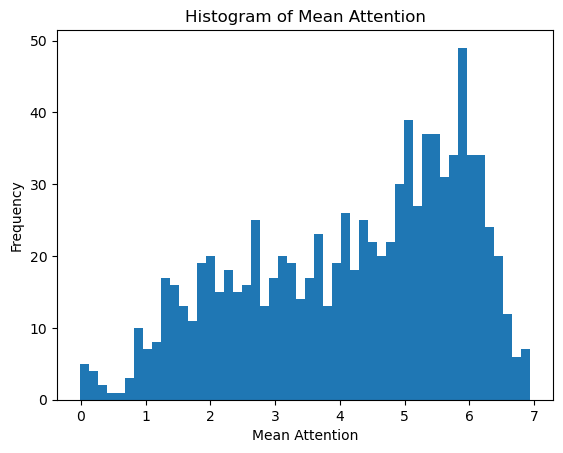

In [15]:
#tum_threshold_value_in_chief=otsu_thresh
dir_path = "/home/shirasuna/work/hetero_path/hetero_cluster/STAD_clustering_pca80var_integrate_mag40_init20/"
dir_path_2 = "/home/shirasuna/work/hetero_path/hetero_cluster/STAD_clustering_pca80var_integrate_mag20_init20/"

samples_with_cluster_all = [
    f for f in os.listdir(dir_path) 
    if os.path.isdir(os.path.join(dir_path,f)) and f.startswith("TCGA")
]
samples_with_cluster_all_2 = [
    f for f in os.listdir(dir_path_2) 
    if os.path.isdir(os.path.join(dir_path_2,f)) and f.startswith("TCGA")
]
samples_with_cluster_all = list(set(samples_with_cluster_all)|set(samples_with_cluster_all_2))

cluster_chief_list = []


#samples_with_cluster = list(set(samples_with_cluster_all)&set(prog_data_name))
samples_with_cluster = list(set(samples_with_cluster_all))
sample_with_prog_set = set(OS_dict.keys()) | set(DSS_dict.keys()) | set(PFS_dict.keys())
samples_with_cluster = list(set(samples_with_cluster)&sample_with_prog_set)



print(len(samples_with_cluster))

    
for temp_sample in samples_with_cluster:
    try:
        path_2_clustering = f"{dir_path}/{temp_sample}"
        optimized_state = np.load(f"{path_2_clustering}/optimized_state.npy")
        h5_file_path = f"/data/shirasuna/work/hetero_path/TCGA_wsi_patch/patched_STAD_mag40/patches/{temp_sample}.h5"
        h5_wsi = h5py.File(h5_file_path, 'r')
    
        EPI_FEATURE_SAVE_DIR_PATH = f"/data/shirasuna/work/hetero_path/UNI_encode_with_mask/features_STAD_mag40/{temp_sample}"
        epi_coords = np.load(f"{EPI_FEATURE_SAVE_DIR_PATH}/coords.npy")
        #epi_features = np.load(f"{EPI_FEATURE_SAVE_DIR_PATH}/features.npy")

    except:
        path_2_clustering = f"{dir_path_2}/{temp_sample}"
        optimized_state = np.load(f"{path_2_clustering}/optimized_state.npy")
        h5_file_path = f"/data/shirasuna/work/hetero_path/TCGA_wsi_patch/patched_STAD_mag20/patches/{temp_sample}.h5"
        h5_wsi = h5py.File(h5_file_path, 'r')
    
        EPI_FEATURE_SAVE_DIR_PATH = f"/data/shirasuna/work/hetero_path/UNI_encode_with_mask/features_STAD_mag20/{temp_sample}"
        epi_coords = np.load(f"{EPI_FEATURE_SAVE_DIR_PATH}/coords.npy")
        #epi_features = np.load(f"{EPI_FEATURE_SAVE_DIR_PATH}/features.npy")
    
    estimated_clone_num= len(np.unique(optimized_state))

    # chief
    chief_result_path =  f"/wsi/analysis/TCGA_TMA_analysis/data/CHIEF/STAD/chief/results/TCGA_Dataset_PT_trident/evaluation/TCGA_CHIEF_test/attention_heatmap_h5_coords_viz_v1/{temp_sample}_patch_attention.csv"
    chief_result_df = pd.read_csv(chief_result_path)

    
    # 4つの近傍のattension valueの平均で各座標のattension valueを定義
    x_coord_chief = chief_result_df["x_coord"].tolist()
    y_coord_chief = chief_result_df["y_coord"].tolist()
    attension_chief_list = chief_result_df["attention_value"].tolist()
    
    coord_chief = np.stack((x_coord_chief, y_coord_chief), axis =1)
    attension_chief_array = np.array(attension_chief_list) # shape=(N,) 例: (2903,)

    # --- KDTree を使用した最近傍探索 ---
    kdtree = KDTree(coord_chief)
    
    # 2. wsi_patch_coords の各点について、coord_tum_chief 内の最近傍点を検索
    #    queryメソッドは、距離(distances)と最近傍点のインデックス(indices)を返します。
    #    k=1 は最も近い1点を探すことを意味します。
    distances, nearest_indices = kdtree.query(epi_coords, k=4)
    
    # nearest_indices は、wsi_patch_coords の各点に対応する、
    # coord_tum_chief 内の最も近い点のインデックス（行番号）を格納した配列です。
    # shape=(M,) 例: (42849,)
    
    # 3. 得られたインデックスを使って、対応する attention 値を取得
    #    attension_chief_array から、nearest_indices を使って値を取り出します。

    wsi_attention_values = attension_chief_array[nearest_indices] # shape=(M,) 例: (42849,)
        
    ###平均のattension valueが4以上のclusterのみカウント

    mean_wsi_attention_values = np.mean(wsi_attention_values, axis=1)
    
    estimated_clone_num=0

    patch_num = 0
    for cluster in np.unique(optimized_state):
        mean_attension = np.sum(mean_wsi_attention_values[optimized_state==cluster])/np.sum(optimized_state==cluster)
        cluster_chief_list.append(mean_attension)


# 大津のしきい値を計算
cluster_chief_array = np.array(cluster_chief_list)
otsu_thresh = threshold_otsu(cluster_chief_array)
min_thresh = threshold_minimum(cluster_chief_array)

# 分割
low_attention = cluster_chief_array[cluster_chief_array <= otsu_thresh]
high_attention = cluster_chief_array[cluster_chief_array > otsu_thresh]

print(f"Otsu threshold: {otsu_thresh}")
print(f"Low attention cluster count: {len(low_attention)}")
print(f"High attention cluster count: {len(high_attention)}")



plt.hist(cluster_chief_list, bins=50)
plt.xlabel("Mean Attention")
plt.ylabel("Frequency")
plt.title("Histogram of Mean Attention")
plt.show()
    
    

Otsu threshold: 3.8575272812517563
Low attention cluster count: 360
High attention cluster count: 575


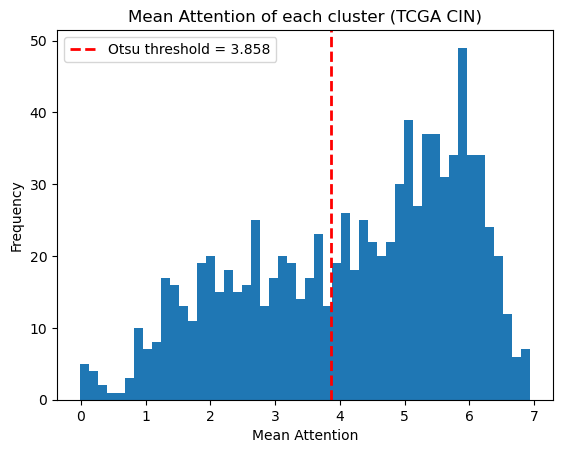

In [17]:

print(f"Otsu threshold: {otsu_thresh}")
print(f"Low attention cluster count: {len(low_attention)}")
print(f"High attention cluster count: {len(high_attention)}")



plt.hist(cluster_chief_list, bins=50)
plt.xlabel("Mean Attention")
plt.ylabel("Frequency")
plt.title("Mean Attention of each cluster (TCGA CIN)")

# ここで赤い縦線を追加
plt.axvline(x=otsu_thresh, color='red', linestyle='--', linewidth=2, label=f'Otsu threshold = {otsu_thresh:.3f}')
plt.legend()

plt.show()

In [17]:
dir_path = "/home/shirasuna/work/hetero_path/hetero_cluster/STAD_clustering_pca80var_integrate_mag40_init20/"
dir_path_2 = "/home/shirasuna/work/hetero_path/hetero_cluster/STAD_clustering_pca80var_integrate_mag20_init20/"

samples_with_cluster_all = [
    f for f in os.listdir(dir_path) 
    if os.path.isdir(os.path.join(dir_path,f)) and f.startswith("TCGA")
]
samples_with_cluster_all_2 = [
    f for f in os.listdir(dir_path_2) 
    if os.path.isdir(os.path.join(dir_path_2,f)) and f.startswith("TCGA")
]

len(list(set(samples_with_cluster_all) | set(samples_with_cluster_all_2)))

393

166


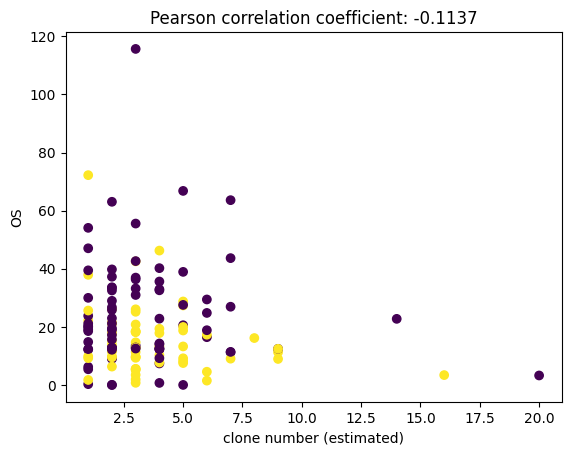

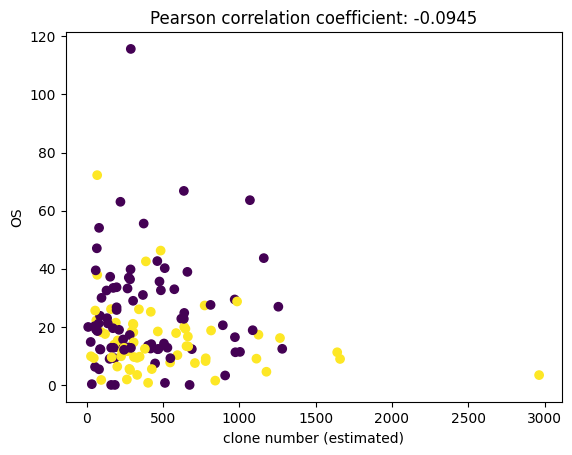

175.5770729200109
637.2071810420043
p=0.031


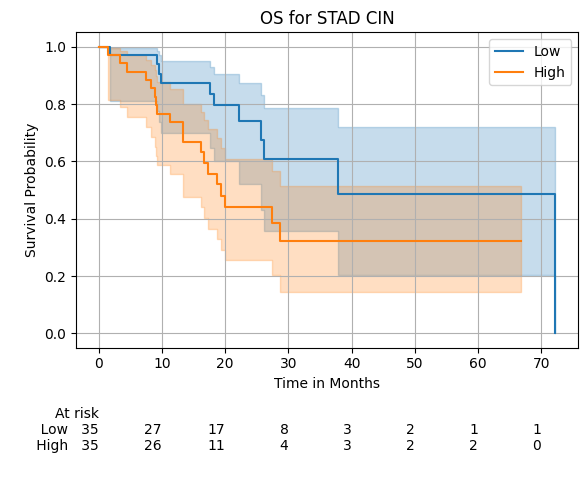

162


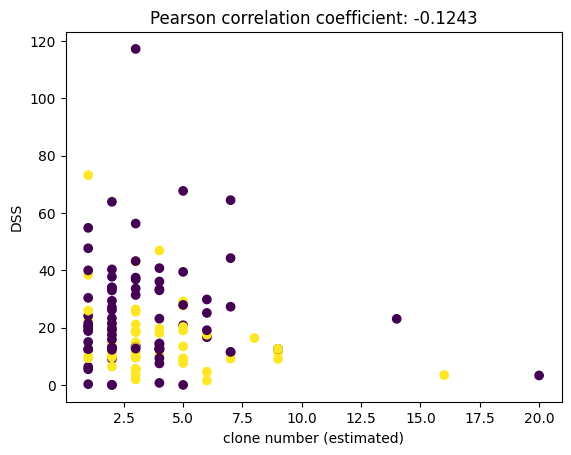

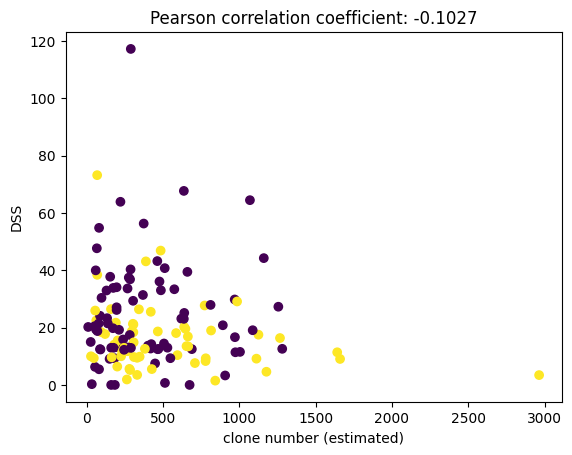

175.99284474480524
637.8960968549256
p=0.010


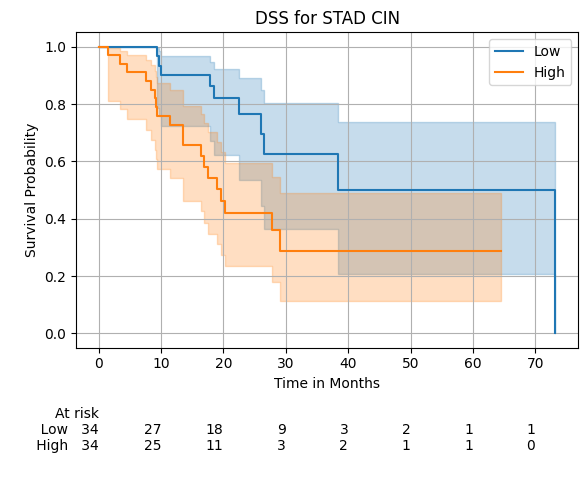

166


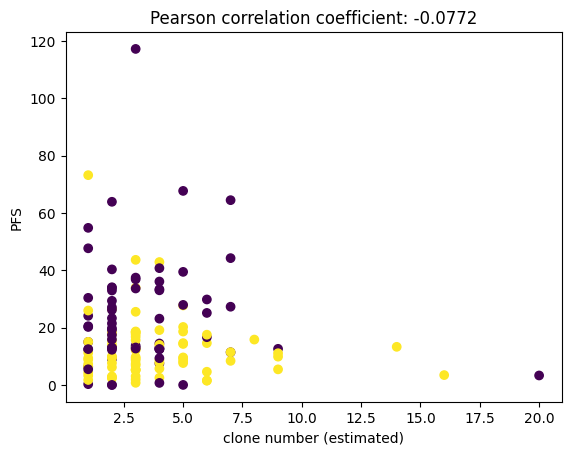

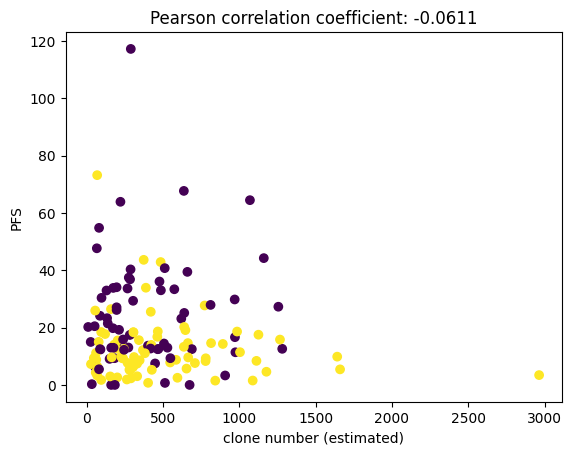

175.5770729200109
637.2071810420043
p=0.215


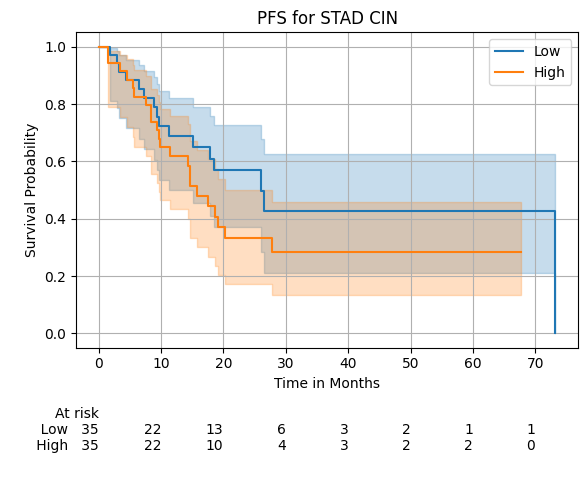

In [20]:
prog_dict_list=[OS_dict, DSS_dict,PFS_dict]
prog_index_dict_list=[OS_index_dict, DSS_index_dict,PFS_index_dict]
metrics_name_list = ["OS", "DSS", "PFS"]

tum_threshold_value_in_chief=otsu_thresh

dir_path = "/home/shirasuna/work/hetero_path/hetero_cluster/STAD_clustering_pca80var_integrate_mag40_init20/"
dir_path_2 = "/home/shirasuna/work/hetero_path/hetero_cluster/STAD_clustering_pca80var_integrate_mag20_init20/"

samples_with_cluster_all = [
    f for f in os.listdir(dir_path) 
    if os.path.isdir(os.path.join(dir_path,f)) and f.startswith("TCGA")
]
samples_with_cluster_all_2 = [
    f for f in os.listdir(dir_path_2) 
    if os.path.isdir(os.path.join(dir_path_2,f)) and f.startswith("TCGA")
]
samples_with_cluster_all = list(set(samples_with_cluster_all)|set(samples_with_cluster_all_2))

###WGSと相関が取れるもののみ使用





for i in range(len(metrics_name_list)):
    prog_dict = prog_dict_list[i]
    prog_index_dict = prog_index_dict_list[i]
    metrics_name=metrics_name_list[i]
    samples_with_cluster = list(set(samples_with_cluster_all)&set(list(prog_dict.keys())))

    print(len(samples_with_cluster))

    prog_list=[]
    samples_for_plot_list=[]
    estimated_clone_num_list = []
    whole_patch_num_list = []
    patch_num_list = []
    tum_whole_ratio_list = []
    
    for temp_sample in samples_with_cluster:
        try:
            path_2_clustering = f"{dir_path}/{temp_sample}"
            optimized_state = np.load(f"{path_2_clustering}/optimized_state.npy")
            h5_file_path = f"/data/shirasuna/work/hetero_path/TCGA_wsi_patch/patched_STAD_mag40/patches/{temp_sample}.h5"
            h5_wsi = h5py.File(h5_file_path, 'r')
        
            EPI_FEATURE_SAVE_DIR_PATH = f"/data/shirasuna/work/hetero_path/UNI_encode_with_mask/features_STAD_mag40/{temp_sample}"
            epi_coords = np.load(f"{EPI_FEATURE_SAVE_DIR_PATH}/coords.npy")
            #epi_features = np.load(f"{EPI_FEATURE_SAVE_DIR_PATH}/features.npy")
    
        except:
            path_2_clustering = f"{dir_path_2}/{temp_sample}"
            optimized_state = np.load(f"{path_2_clustering}/optimized_state.npy")
            h5_file_path = f"/data/shirasuna/work/hetero_path/TCGA_wsi_patch/patched_STAD_mag20/patches/{temp_sample}.h5"
            h5_wsi = h5py.File(h5_file_path, 'r')
        
            EPI_FEATURE_SAVE_DIR_PATH = f"/data/shirasuna/work/hetero_path/UNI_encode_with_mask/features_STAD_mag20/{temp_sample}"
            epi_coords = np.load(f"{EPI_FEATURE_SAVE_DIR_PATH}/coords.npy")
            #epi_features = np.load(f"{EPI_FEATURE_SAVE_DIR_PATH}/features.npy")
    
        # chief
        chief_result_path =  f"/wsi/analysis/TCGA_TMA_analysis/data/CHIEF/STAD/chief/results/TCGA_Dataset_PT_trident/evaluation/TCGA_CHIEF_test/attention_heatmap_h5_coords_viz_v1/{temp_sample}_patch_attention.csv"
        chief_result_df = pd.read_csv(chief_result_path)
    
        
        # 4つの近傍のattension valueの平均で各座標のattension valueを定義
        x_coord_chief = chief_result_df["x_coord"].tolist()
        y_coord_chief = chief_result_df["y_coord"].tolist()
        attension_chief_list = chief_result_df["attention_value"].tolist()
        
        coord_chief = np.stack((x_coord_chief, y_coord_chief), axis =1)
        attension_chief_array = np.array(attension_chief_list) # shape=(N,) 例: (2903,)

        # --- KDTree を使用した最近傍探索 ---
        kdtree = KDTree(coord_chief)
        
        # 2. wsi_patch_coords の各点について、coord_tum_chief 内の最近傍点を検索
        #    queryメソッドは、距離(distances)と最近傍点のインデックス(indices)を返します。
        #    k=1 は最も近い1点を探すことを意味します。
        distances, nearest_indices = kdtree.query(epi_coords, k=4)
        
        # nearest_indices は、wsi_patch_coords の各点に対応する、
        # coord_tum_chief 内の最も近い点のインデックス（行番号）を格納した配列です。
        # shape=(M,) 例: (42849,)
        
        # 3. 得られたインデックスを使って、対応する attention 値を取得
        #    attension_chief_array から、nearest_indices を使って値を取り出します。

        wsi_attention_values = attension_chief_array[nearest_indices] # shape=(M,) 例: (42849,)
        
        ###平均のattension valueが4以上のclusterのみカウント
    
        mean_wsi_attention_values = np.mean(wsi_attention_values, axis=1)
        
        estimated_clone_num=0

        patch_num = 0
        for cluster in np.unique(optimized_state):
            mean_attension = np.sum(mean_wsi_attention_values[optimized_state==cluster])/np.sum(optimized_state==cluster)
            if mean_attension > tum_threshold_value_in_chief:
                estimated_clone_num+=1
                patch_num+=np.sum(optimized_state==cluster)
    
    
        # 例: create_knn_graph の出力を使用
    
        """
       
        g, nodes, nx_graph = create_knn_graph(epi_coords, k=4)  # coords は事前に定義されているとする
        cluster_components, cluster_component_ratios = compute_cluster_connected_components(nx_graph, optimized_state)
        
        print(f"クラスタごとの連結成分数: {cluster_components}")
        
        estimated_clone_num=0
        
        for cluster in cluster_component_ratios.keys():
            #if max(cluster_component_ratios[cluster])>0.25 and sum(optimized_state==cluster)/len(optimized_state)>1/len(np.unique(optimized_state))/5:
            if max(cluster_component_ratios[cluster])*sum(optimized_state==cluster) > 0.01*len(optimized_state):
                estimated_clone_num+=1
        """
        #estimated_clone_num= len(np.unique(optimized_state))
    
        
        prog_time = prog_dict[temp_sample]
        whole_patch_num= len(h5_wsi["coords"])
    
        samples_for_plot_list.append(temp_sample)
        prog_list.append(prog_time)
        estimated_clone_num_list.append(estimated_clone_num)
        patch_num_list.append(patch_num)
        whole_patch_num_list.append(whole_patch_num)
        tum_whole_ratio_list.append(patch_num/whole_patch_num)

    """
    patch_25 = np.percentile(whole_patch_num_list, 5)
    patch_75 = np.percentile(whole_patch_num_list, 95)
    
    filtered_samples_for_plot_list=[]
    filtered_prog_list = []
    filtered_estimated_clone_num_list = []
    filtered_whole_patch_num_list = []
    filtered_patch_num_list = []
    filtered_tum_whole_ratio_list = []
    
    for i in range(len(samples_for_plot_list)):
        if patch_25<whole_patch_num_list[i] and patch_75>whole_patch_num_list[i]:
            filtered_samples_for_plot_list.append(samples_for_plot_list[i])
            filtered_prog_list.append(prog_list[i])
            filtered_estimated_clone_num_list.append(estimated_clone_num_list[i])
            filtered_whole_patch_num_list.append(whole_patch_num_list[i])
            filtered_patch_num_list.append(patch_num_list[i])
            filtered_tum_whole_ratio_list.append(tum_whole_ratio_list[i])


    """
    patch_25 = np.percentile(patch_num_list, 5)
    patch_75 = np.percentile(patch_num_list, 95)
    
    filtered_samples_for_plot_list=[]
    filtered_prog_list = []
    filtered_estimated_clone_num_list = []
    filtered_whole_patch_num_list = []
    filtered_patch_num_list = []
    filtered_tum_whole_ratio_list = []
    
    for i in range(len(samples_for_plot_list)):
        if patch_25<patch_num_list[i] and patch_75>patch_num_list[i]:
            filtered_samples_for_plot_list.append(samples_for_plot_list[i])
            filtered_prog_list.append(prog_list[i])
            filtered_estimated_clone_num_list.append(estimated_clone_num_list[i])
            filtered_whole_patch_num_list.append(whole_patch_num_list[i])
            filtered_patch_num_list.append(patch_num_list[i])
            filtered_tum_whole_ratio_list.append(tum_whole_ratio_list[i])

    
    filtered_scaled_estimated_clone_num_list = [filtered_estimated_clone_num_list[i]*(filtered_patch_num_list[i])**(1/2) for i in range(len(filtered_patch_num_list))]

    event_list = []
    for temp_sample in filtered_samples_for_plot_list:
        temp_index = prog_index_dict[temp_sample]
        if temp_index ==0:
            event_list.append(0)
        else:
            event_list.append(1)
    

    
    corr_pearson = np.corrcoef(filtered_estimated_clone_num_list, filtered_prog_list)[0, 1]
    #print(f"Pearson correlation coefficient: {corr_pearson:.4f}")
    plt.scatter(filtered_estimated_clone_num_list, filtered_prog_list,c=event_list)
    plt.title(f"Pearson correlation coefficient: {corr_pearson:.4f}")
    plt.xlabel("clone number (estimated)")
    plt.ylabel(metrics_name) 
    plt.show()

    corr_pearson = np.corrcoef(filtered_scaled_estimated_clone_num_list, filtered_prog_list)[0, 1]
    #print(f"Pearson correlation coefficient: {corr_pearson:.4f}")
    plt.scatter(filtered_scaled_estimated_clone_num_list, filtered_prog_list,c=event_list)
    plt.title(f"Pearson correlation coefficient: {corr_pearson:.4f}")
    plt.xlabel("clone number (estimated)")
    plt.ylabel(metrics_name) 
    plt.show()





    low_threshold = np.percentile(filtered_scaled_estimated_clone_num_list, 25)
    high_threshold = np.percentile(filtered_scaled_estimated_clone_num_list,75)
    print(low_threshold)
    print(high_threshold)

    
    # 上位25%（Q3以上）と下位25%（Q1以下）のインデックスを抽出
    group0_indices = [i for i, val in enumerate(filtered_scaled_estimated_clone_num_list) if val <= low_threshold]
    group1_indices = [i for i, val in enumerate(filtered_scaled_estimated_clone_num_list) if val > high_threshold]

    

    # 対応する生存時間とイベント情報を取得
    T = np.array(filtered_prog_list)
    E = np.array(event_list)
    
    # グループごとのデータ
    T0, E0 = T[group0_indices], E[group0_indices]
    T1, E1 = T[group1_indices], E[group1_indices]

    """
    # KMプロット
    kmf = KaplanMeierFitter()
    plt.figure()
    
    kmf.fit(T0, event_observed=E0, label="Low")
    kmf.plot_survival_function()
    
    kmf.fit(T1, event_observed=E1, label="High")
    kmf.plot_survival_function()

    # Log-rank test
    results = logrank_test(T0, T1, event_observed_A=E0, event_observed_B=E1,  weightings='wilcoxon')

    print(f"p={results.p_value:.3f}")
    plt.title(f"{metrics_name} for STAD CIN")
    plt.xlabel("Time in Months")
    plt.ylabel(f"Survival Probability")
    plt.legend()
    plt.grid(True)

    
    plt.show()
    """
    

    # 2つのグループ用に別々のKaplanMeierFitterインスタンスを用意
    kmf_low = KaplanMeierFitter()
    kmf_high = KaplanMeierFitter()
    
    # FigureとAxesオブジェクトを先に作成
    fig, ax = plt.subplots(figsize=(6, 5))
    
    # Lowグループの生存曲線をプロット
    # ★ show_censors=False を追加して打ち切りマーカーを非表示に
    kmf_low.fit(T0, event_observed=E0, label="Low")
    kmf_low.plot_survival_function(ax=ax, show_censors=False)
    
    # Highグループの生存曲線をプロット
    # ★ こちらにも同様に追加
    kmf_high.fit(T1, event_observed=E1, label="High")
    kmf_high.plot_survival_function(ax=ax, show_censors=False)
    
    # Number at Risk テーブルを追加
    add_at_risk_counts(kmf_low, kmf_high, ax=ax, rows_to_show=['At risk'])
    
    # Log-rank test
    results = logrank_test(T0, T1, event_observed_A=E0, event_observed_B=E1)
    
    # プロットの体裁を整える
    print(f"p={results.p_value:.3f}")
    ax.set_title(f"{metrics_name} for STAD CIN")
    ax.set_xlabel("Time in Months")
    ax.set_ylabel("Survival Probability")
    ax.legend()
    ax.grid(True)
    
    plt.tight_layout() # プロットが重ならないように調整
    plt.show()
    

# cox比例ハザード

166


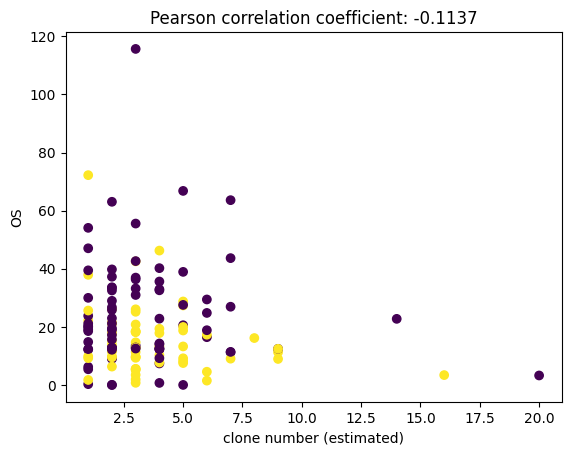

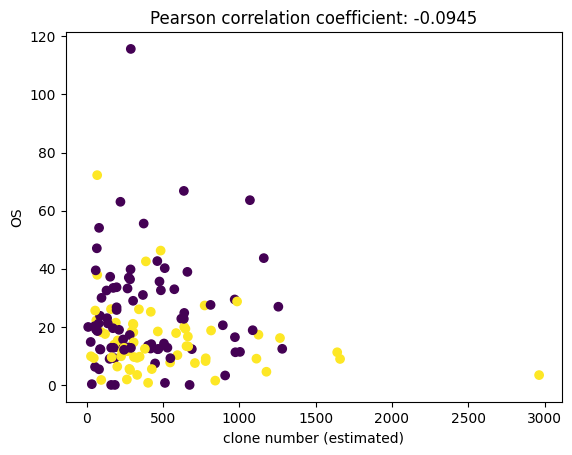

OS


<lifelines.CoxPHFitter: fitted with 71 total observations, 41 right-censored observations>
             duration col = 'duration'
                event col = 'event'
      baseline estimation = breslow
   number of observations = 71
number of events observed = 30
   partial log-likelihood = -98.83
         time fit was run = 2025-07-17 09:39:21 UTC

---
            coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                   
age         0.04      1.04      0.02           -0.01            0.08                0.99                1.08
clone_num   1.11      3.02      0.42            0.28            1.93                1.32                6.91
tumor_T3_4  0.92      2.51      0.53           -0.12            1.96                0.89                7.11
node_N1     0.48      1.61      0.61           -0.71            1.67                0.49                5.30
node_N2     0.78      2.18      0.57           -0.34            1.90                0.71                6.67
node_N3     0.22      1.25      0.66           -1.08            1.52                0.34                4.59

            cmp to    z    p  -log2(p)
covariate                             
age           0.00 1.65 0.10      3.34
clone_num     0.00 2.62 0.01      6.82
tumor_T3_4    0.00 1.74 0.08      3.60
node_N1       0.00 0.79 0.43      1.22
node_N2       0.00 1.36 0.17      2.54
node_N3       0.00 0.34 0.74      0.44
---
Concordance = 0.73
Partial AIC = 209.65
log-likelihood ratio test = 13.72 on 6 df
-log2(p) of ll-ratio test = 4.93

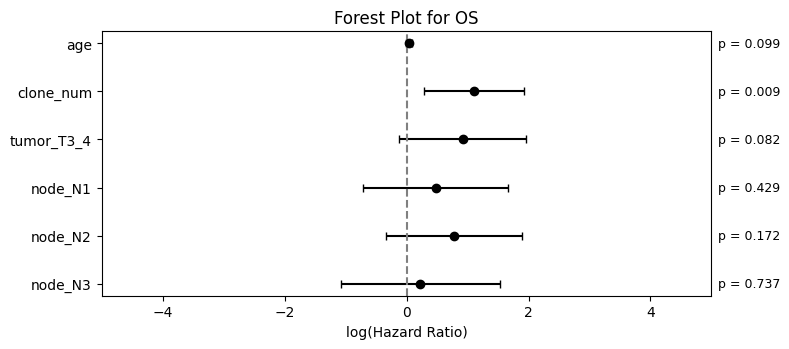

162


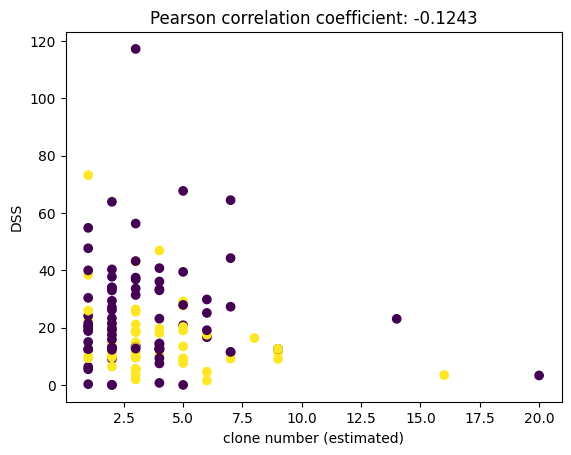

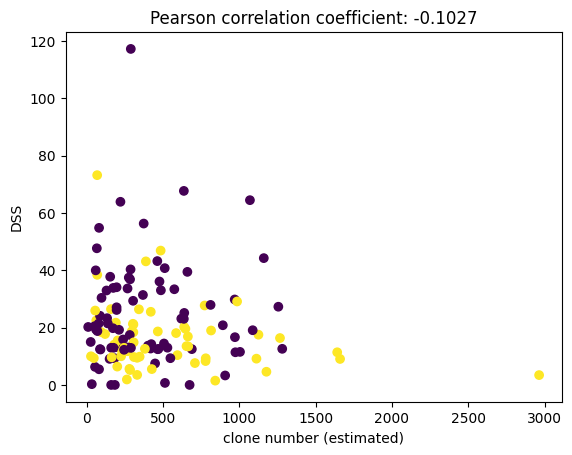

DSS


<lifelines.CoxPHFitter: fitted with 69 total observations, 40 right-censored observations>
             duration col = 'duration'
                event col = 'event'
      baseline estimation = breslow
   number of observations = 69
number of events observed = 29
   partial log-likelihood = -93.79
         time fit was run = 2025-07-17 09:39:30 UTC

---
            coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                   
age         0.03      1.03      0.02           -0.01            0.08                0.99                1.08
clone_num   1.29      3.65      0.44            0.44            2.15                1.55                8.62
tumor_T3_4  0.77      2.16      0.52           -0.26            1.80                0.77                6.02
node_N1     0.22      1.24      0.62           -1.00            1.43                0.37                4.17
node_N2     0.75      2.12      0.56           -0.35            1.85                0.70                6.35
node_N3     0.11      1.11      0.66           -1.19            1.40                0.31                4.04

            cmp to    z      p  -log2(p)
covariate                               
age           0.00 1.50   0.13      2.90
clone_num     0.00 2.95 <0.005      8.31
tumor_T3_4    0.00 1.47   0.14      2.82
node_N1       0.00 0.35   0.73      0.46
node_N2       0.00 1.34   0.18      2.46
node_N3       0.00 0.16   0.87      0.20
---
Concordance = 0.74
Partial AIC = 199.58
log-likelihood ratio test = 13.56 on 6 df
-log2(p) of ll-ratio test = 4.84

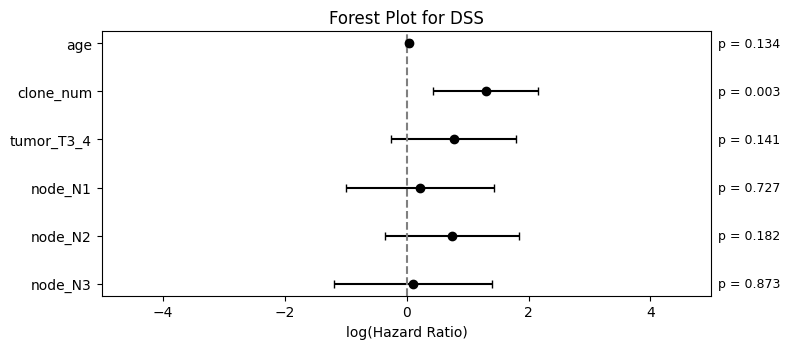

166


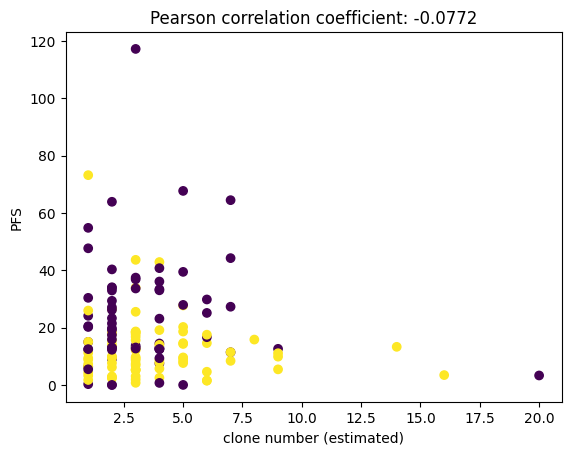

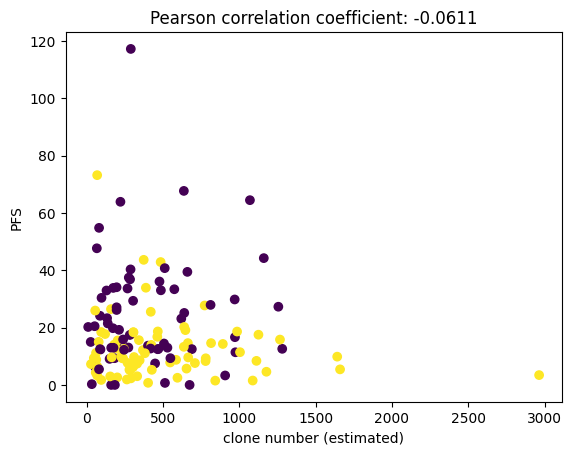

PFS


<lifelines.CoxPHFitter: fitted with 71 total observations, 33 right-censored observations>
             duration col = 'duration'
                event col = 'event'
      baseline estimation = breslow
   number of observations = 71
number of events observed = 38
   partial log-likelihood = -132.95
         time fit was run = 2025-07-17 09:39:39 UTC

---
            coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                   
age         0.01      1.01      0.02           -0.03            0.05                0.98                1.05
clone_num   0.52      1.68      0.36           -0.20            1.23                0.82                3.44
tumor_T3_4 -0.06      0.94      0.41           -0.87            0.75                0.42                2.12
node_N1     0.67      1.95      0.52           -0.36            1.70                0.70                5.46
node_N2     1.07      2.93      0.49            0.10            2.04                1.11                7.71
node_N3     0.77      2.17      0.60           -0.40            1.95                0.67                7.05

            cmp to     z    p  -log2(p)
covariate                              
age           0.00  0.63 0.53      0.93
clone_num     0.00  1.42 0.15      2.69
tumor_T3_4    0.00 -0.15 0.88      0.18
node_N1       0.00  1.28 0.20      2.32
node_N2       0.00  2.17 0.03      5.06
node_N3       0.00  1.29 0.20      2.34
---
Concordance = 0.64
Partial AIC = 277.89
log-likelihood ratio test = 6.90 on 6 df
-log2(p) of ll-ratio test = 1.60

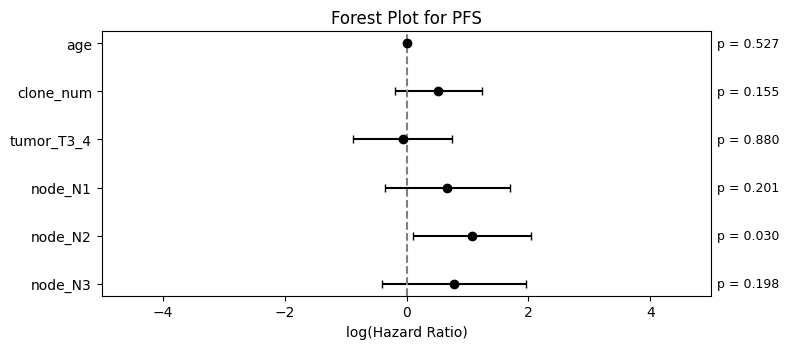

In [21]:
prog_dict_list=[OS_dict, DSS_dict,PFS_dict]
prog_index_dict_list=[OS_index_dict, DSS_index_dict,PFS_index_dict]
metrics_name_list = ["OS", "DSS", "PFS"]

tum_threshold_value_in_chief=otsu_thresh

dir_path = "/home/shirasuna/work/hetero_path/hetero_cluster/STAD_clustering_pca80var_integrate_mag40_init20/"
dir_path_2 = "/home/shirasuna/work/hetero_path/hetero_cluster/STAD_clustering_pca80var_integrate_mag20_init20/"

samples_with_cluster_all = [
    f for f in os.listdir(dir_path) 
    if os.path.isdir(os.path.join(dir_path,f)) and f.startswith("TCGA")
]
samples_with_cluster_all_2 = [
    f for f in os.listdir(dir_path_2) 
    if os.path.isdir(os.path.join(dir_path_2,f)) and f.startswith("TCGA")
]
samples_with_cluster_all = list(set(samples_with_cluster_all)|set(samples_with_cluster_all_2))



for i in range(len(metrics_name_list)):
    prog_dict = prog_dict_list[i]
    prog_index_dict = prog_index_dict_list[i]
    metrics_name=metrics_name_list[i]
    samples_with_cluster = list(set(samples_with_cluster_all)&set(list(prog_dict.keys())))

    
    prog_list=[]
    samples_for_plot_list=[]
    estimated_clone_num_list = []
    whole_patch_num_list = []
    patch_num_list = []
    tum_whole_ratio_list = []

    print(len(samples_with_cluster))
    for temp_sample in samples_with_cluster:
        try:
            path_2_clustering = f"{dir_path}/{temp_sample}"
            optimized_state = np.load(f"{path_2_clustering}/optimized_state.npy")
            h5_file_path = f"/data/shirasuna/work/hetero_path/TCGA_wsi_patch/patched_STAD_mag40/patches/{temp_sample}.h5"
            h5_wsi = h5py.File(h5_file_path, 'r')
        
            EPI_FEATURE_SAVE_DIR_PATH = f"/data/shirasuna/work/hetero_path/UNI_encode_with_mask/features_STAD_mag40/{temp_sample}"
            epi_coords = np.load(f"{EPI_FEATURE_SAVE_DIR_PATH}/coords.npy")
            #epi_features = np.load(f"{EPI_FEATURE_SAVE_DIR_PATH}/features.npy")
    
        except:
            path_2_clustering = f"{dir_path_2}/{temp_sample}"
            optimized_state = np.load(f"{path_2_clustering}/optimized_state.npy")
            h5_file_path = f"/data/shirasuna/work/hetero_path/TCGA_wsi_patch/patched_STAD_mag20/patches/{temp_sample}.h5"
            h5_wsi = h5py.File(h5_file_path, 'r')
        
            EPI_FEATURE_SAVE_DIR_PATH = f"/data/shirasuna/work/hetero_path/UNI_encode_with_mask/features_STAD_mag20/{temp_sample}"
            epi_coords = np.load(f"{EPI_FEATURE_SAVE_DIR_PATH}/coords.npy")
            #epi_features = np.load(f"{EPI_FEATURE_SAVE_DIR_PATH}/features.npy")
    
        #estimated_clone_num= len(np.unique(optimized_state))
    
        # chief
        chief_result_path =  f"/wsi/analysis/TCGA_TMA_analysis/data/CHIEF/STAD/chief/results/TCGA_Dataset_PT_trident/evaluation/TCGA_CHIEF_test/attention_heatmap_h5_coords_viz_v1/{temp_sample}_patch_attention.csv"
        chief_result_df = pd.read_csv(chief_result_path)
    
        
        # 4つの近傍のattension valueの平均で各座標のattension valueを定義
        x_coord_chief = chief_result_df["x_coord"].tolist()
        y_coord_chief = chief_result_df["y_coord"].tolist()
        attension_chief_list = chief_result_df["attention_value"].tolist()
        
        coord_chief = np.stack((x_coord_chief, y_coord_chief), axis =1)
        attension_chief_array = np.array(attension_chief_list) # shape=(N,) 例: (2903,)

        # --- KDTree を使用した最近傍探索 ---
        kdtree = KDTree(coord_chief)
        
        # 2. wsi_patch_coords の各点について、coord_tum_chief 内の最近傍点を検索
        #    queryメソッドは、距離(distances)と最近傍点のインデックス(indices)を返します。
        #    k=1 は最も近い1点を探すことを意味します。
        distances, nearest_indices = kdtree.query(epi_coords, k=4)
        
        # nearest_indices は、wsi_patch_coords の各点に対応する、
        # coord_tum_chief 内の最も近い点のインデックス（行番号）を格納した配列です。
        # shape=(M,) 例: (42849,)
        
        # 3. 得られたインデックスを使って、対応する attention 値を取得
        #    attension_chief_array から、nearest_indices を使って値を取り出します。

        wsi_attention_values = attension_chief_array[nearest_indices] # shape=(M,) 例: (42849,)
        
        ###平均のattension valueが4以上のclusterのみカウント
    
        mean_wsi_attention_values = np.mean(wsi_attention_values, axis=1)
        
        estimated_clone_num=0

        patch_num = 0
        for cluster in np.unique(optimized_state):
            mean_attension = np.sum(mean_wsi_attention_values[optimized_state==cluster])/np.sum(optimized_state==cluster)
            if mean_attension > tum_threshold_value_in_chief:
                estimated_clone_num+=1
                patch_num+=np.sum(optimized_state==cluster)
    
    
        # 例: create_knn_graph の出力を使用


        
        prog_time = prog_dict[temp_sample]
        whole_patch_num= len(h5_wsi["coords"])
    
        samples_for_plot_list.append(temp_sample)
        prog_list.append(prog_time)
        estimated_clone_num_list.append(estimated_clone_num)
        patch_num_list.append(patch_num)
        whole_patch_num_list.append(whole_patch_num)
        tum_whole_ratio_list.append(patch_num/whole_patch_num)


    
    patch_25 = np.percentile(patch_num_list,5)
    patch_75 = np.percentile(patch_num_list, 95)
    
    filtered_samples_for_plot_list=[]
    filtered_prog_list = []
    filtered_estimated_clone_num_list = []
    filtered_whole_patch_num_list = []
    filtered_patch_num_list = []
    filtered_tum_whole_ratio_list = []
    
    for i in range(len(samples_for_plot_list)):
        if patch_25< patch_num_list[i] and patch_75> patch_num_list[i]:
            filtered_samples_for_plot_list.append(samples_for_plot_list[i])
            filtered_prog_list.append(prog_list[i])
            filtered_estimated_clone_num_list.append(estimated_clone_num_list[i])
            filtered_whole_patch_num_list.append(whole_patch_num_list[i])
            filtered_patch_num_list.append(patch_num_list[i])
            filtered_tum_whole_ratio_list.append(tum_whole_ratio_list[i])
    


    filtered_scaled_estimated_clone_num_list = [filtered_estimated_clone_num_list[i]*(filtered_patch_num_list[i])**(1/2) for i in range(len(filtered_patch_num_list))]

    
    event_list = []
    for temp_sample in filtered_samples_for_plot_list:
        #temp_index = int(prog_index_dict[temp_sample][0])
        temp_index = prog_index_dict[temp_sample]
        if temp_index ==0:
            event_list.append(0)
        else:
            event_list.append(1)
    

    
    corr_pearson = np.corrcoef(filtered_estimated_clone_num_list, filtered_prog_list)[0, 1]
    #print(f"Pearson correlation coefficient: {corr_pearson:.4f}")
    plt.scatter(filtered_estimated_clone_num_list, filtered_prog_list,c=event_list)
    plt.title(f"Pearson correlation coefficient: {corr_pearson:.4f}")
    plt.xlabel("clone number (estimated)")
    plt.ylabel(metrics_name) 
    plt.show()

    corr_pearson = np.corrcoef(filtered_scaled_estimated_clone_num_list, filtered_prog_list)[0, 1]
    #print(f"Pearson correlation coefficient: {corr_pearson:.4f}")
    plt.scatter(filtered_scaled_estimated_clone_num_list, filtered_prog_list,c=event_list)
    plt.title(f"Pearson correlation coefficient: {corr_pearson:.4f}")
    plt.xlabel("clone number (estimated)")
    plt.ylabel(metrics_name) 
    plt.show()



    
    low_threshold = np.percentile(filtered_scaled_estimated_clone_num_list, 25)
    high_threshold = np.percentile(filtered_scaled_estimated_clone_num_list, 75)

        

    # 上位25%（Q3以上）と下位25%（Q1以下）のインデックスを抽出
    group0_indices = [i for i, val in enumerate(filtered_scaled_estimated_clone_num_list) if val <= low_threshold]
    group1_indices = [i for i, val in enumerate(filtered_scaled_estimated_clone_num_list) if val > high_threshold]
    
    

    # 対応する生存時間とイベント情報を取得
    T = np.array(filtered_prog_list)
    E = np.array(event_list)
    
    # グループごとのデータ
    T0, E0 = T[group0_indices], E[group0_indices]
    T1, E1 = T[group1_indices], E[group1_indices]

    # age data
    A0 = [age_dict[filtered_samples_for_plot_list[temp_idx]] for temp_idx in group0_indices]
    A1 = [age_dict[filtered_samples_for_plot_list[temp_idx]] for temp_idx in group1_indices]

    #state_data
    tumor0 = [T_dict[filtered_samples_for_plot_list[temp_idx]] for temp_idx in group0_indices]
    tumor0 = ["T1_2" if t in ["T1", "T2"] else "T3_4" if t in ["T3", "T4"] else t for t in tumor0]
    tumor1 = [T_dict[filtered_samples_for_plot_list[temp_idx]] for temp_idx in group1_indices]
    tumor1 = ["T1_2" if t in ["T1", "T2"] else "T3_4" if t in ["T3", "T4"] else t for t in tumor1]


    #node_data
    node0 = [N_dict[filtered_samples_for_plot_list[temp_idx]] for temp_idx in group0_indices]
    node0 = ["N3" if t in ["N3A", "N3B"] else t for t in node0]

    # node0 = ["NX" if n.startswith("NX") else
    #     "N01" if n.startswith("N0") else
    #  "N01" if n.startswith("N1") else
    # "N23" for n in node0]
    
    node1 = [N_dict[filtered_samples_for_plot_list[temp_idx]] for temp_idx in group1_indices]
    node1 = ["N3" if t in ["N3A", "N3B"] else t for t in node1]

    
    # node1 = ["NX" if n.startswith("NX") else
    #     "N01" if n.startswith("N0") else
    #  "N01" if n.startswith("N1") else
    # "N23" for n in node1]
    
    # meta data
    meta0 = [M_dict[filtered_samples_for_plot_list[temp_idx]] for temp_idx in group0_indices]
    meta1 = [M_dict[filtered_samples_for_plot_list[temp_idx]] for temp_idx in group1_indices]
    
    df = pd.DataFrame({
        "duration": list(T0) + list(T1),
        "event": list(E0) + list(E1),
        "age": A0+A1,
        "tumor": tumor0+tumor1,
        "node": node0+node1,
        #"meta": meta0+meta1,
        #"stage": S0+S1,
        "clone_num": [0]*len(T0) + [1]*len(T1)  # Low=0, High=1
    })

    df = df[~df["node"].isin(["NX"])]
    df = df[~df["tumor"].isin(["TX"])]
    df = df.dropna(subset=["age"])
    
    df = pd.get_dummies(df, columns=["tumor", "node"], drop_first=True)

    cph = CoxPHFitter()
    cph.fit(df, duration_col="duration", event_col="event")
    
    # 結果表示
    print(metrics_name)
    cph.print_summary()

    # log(HR)（coef）と95% CIを取得
    summary_df = cph.summary.reset_index()
    summary_df = summary_df.rename(columns={"covariate": "variable"})  # ここが重要！
    summary_df = summary_df[summary_df["variable"] != "node_NX"]
    
    log_hr = summary_df["coef"]
    ci_lower = summary_df["coef lower 95%"]
    ci_upper = summary_df["coef upper 95%"]
    variables = summary_df["variable"]
    p_values = summary_df["p"]
    
    # NaN/inf を除外
    valid_idx = log_hr.replace([np.inf, -np.inf], np.nan).notnull()
    log_hr = log_hr[valid_idx]
    ci_lower = ci_lower[valid_idx]
    ci_upper = ci_upper[valid_idx]
    variables = variables[valid_idx]
    p_values = p_values[valid_idx]
    
    # プロット
    plt.figure(figsize=(8, len(log_hr) * 0.6))
    plt.errorbar(log_hr, range(len(log_hr)),
                 xerr=[log_hr - ci_lower, ci_upper - log_hr],
                 fmt='o', color='black', capsize=3)
    
    plt.yticks(range(len(variables)), variables)
    plt.axvline(0, color='gray', linestyle='--')  # log(HR)=0 → HR=1
    plt.xlabel("log(Hazard Ratio)")
    plt.title(f"Forest Plot for {metrics_name}")
    plt.xlim(-5, 5)
    
    # p値を右に表示
    for i, p in enumerate(p_values):
        if np.isfinite(p):
            plt.text(5.1, i, f"p = {p:.3f}", va='center', fontsize=9)
    
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()
    

# 使用したdataについて

In [22]:
###使用したdataのsummary 
dir_path = "/home/shirasuna/work/hetero_path/hetero_cluster/STAD_clustering_pca80var_integrate_mag40_init20/"
dir_path_2 = "/home/shirasuna/work/hetero_path/hetero_cluster/STAD_clustering_pca80var_integrate_mag20_init20/"

samples_with_cluster_all = [
    f for f in os.listdir(dir_path) 
    if os.path.isdir(os.path.join(dir_path,f)) and f.startswith("TCGA")
]
samples_with_cluster_all_2 = [
    f for f in os.listdir(dir_path_2) 
    if os.path.isdir(os.path.join(dir_path_2,f)) and f.startswith("TCGA")
]


sample_with_cluster_set=set(samples_with_cluster_all) | set(samples_with_cluster_all_2)
sample_with_prog_set = set(OS_dict.keys()) | set(DSS_dict.keys()) | set(PFS_dict.keys())


used_samples_for_metrics = list(sample_with_cluster_set & sample_with_prog_set)

used_samples_for_metrics = [ "-".join(s.split("-")[:4])[:-1] for s in used_samples_for_metrics]

In [23]:
tcga_rep_data_tableone = tcga_rep_data[tcga_rep_data["Sample ID"].isin(used_samples_for_metrics)]

In [24]:
columns_need_list = ['Diagnosis Age', 
                      'Sex',
                      'American Joint Committee on Cancer Tumor Stage Code',
                      'Neoplasm Disease Lymph Node Stage American Joint Committee on Cancer Code',
                      'Overall Survival Status','Overall Survival (Months)',
                      'Disease-specific Survival status', 'Months of disease-specific survival',
                      'Progression Free Status', 'Progress Free Survival (Months)']



In [25]:
categorical = ['Sex', 'American Joint Committee on Cancer Tumor Stage Code','Neoplasm Disease Lymph Node Stage American Joint Committee on Cancer Code',
               'Overall Survival Status', 'Disease-specific Survival status', 'Progression Free Status']
continuous = ['Diagnosis Age', 'Overall Survival (Months)', 'Months of disease-specific survival', 'Progress Free Survival (Months)']

In [26]:
mytable = TableOne(tcga_rep_data_tableone, columns_need_list, categorical, continuous)

/home/shirasuna/anaconda3/envs/hetmap_analysis/lib/python3.9/site-packages/tableone/tableone.py:351: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[self._categorical] = handle_categorical_nulls(data[self._categorical], self._categorical)


In [27]:
mytable

Missing      Overall
n                                                                                                                            166
Diagnosis Age, mean (SD)                                                                                          1   65.6 (9.5)
Sex, n (%)                                                                       Female                                55 (33.1)
                                                                                 Male                                 111 (66.9)
American Joint Committee on Cancer Tumor Stage Code, n (%)                       T1                                      2 (1.2)
                                                                                 T1B                                     2 (1.2)
                                                                                 T2                                    28 (16.9)
                                                                                 T2A                                     2 (1.2)
                                                                                 T2B                                     7 (4.2)
                                                                                 T3                                    83 (50.0)
                                                                                 T4                                     10 (6.0)
                                                                                 T4A                                   23 (13.9)
                                                                                 T4B                                     9 (5.4)
Neoplasm Disease Lymph Node Stage American Joint Committee on Cancer Code, n (%) N0                                    48 (28.9)
                                                                                 N1                                    41 (24.7)
                                                                                 N2                                    43 (25.9)
                                                                                 N3                                     12 (7.2)
                                                                                 N3A                                   20 (12.0)
                                                                                 N3B                                     1 (0.6)
                                                                                 NX                                      1 (0.6)
Overall Survival Status, n (%)                                                   0:LIVING                              99 (59.6)
                                                                                 1:DECEASED                            67 (40.4)
Overall Survival (Months), mean (SD)                                                                              0  20.5 (17.8)
Disease-specific Survival status, n (%)                                          0:ALIVE OR DEAD TUMOR FREE           118 (71.1)
                                                                                 1:DEAD WITH TUMOR                     44 (26.5)
                                                                                 None                                    4 (2.4)
Months of disease-specific survival, mean (SD)                                                                    0  20.5 (17.8)
Progression Free Status, n (%)                                                   0:CENSORED                           106 (63.9)
                                                                                 1:PROGRESSION                         60 (36.1)
Progress Free Survival (Months), mean (SD)                                                                        0  18.2 (17.9)

In [26]:
print(mytable.tabulate(tablefmt="github"))

|                                                                                  |                            | Missing   | Overall     |
|----------------------------------------------------------------------------------|----------------------------|-----------|-------------|
| n                                                                                |                            |           | 166         |
| Diagnosis Age, mean (SD)                                                         |                            | 1         | 65.6 (9.5)  |
| Sex, n (%)                                                                       | Female                     |           | 55 (33.1)   |
|                                                                                  | Male                       |           | 111 (66.9)  |
| American Joint Committee on Cancer Tumor Stage Code, n (%)                       | T1                         |           | 2 (1.2)     |
|                   